## Data Preprocessing

In [1]:
import os
import requests
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import LabelEncoder

# xkcd-styled & humor sans font installed to give semi-sarcasm graph
plt.xkcd()
%matplotlib inline

### Constants and Helper Functions

In [2]:
# consts
TUNGUZ_DATASET_REPO_URL = 'https://raw.githubusercontent.com/tunguz/TabularBenchmarks/main/datasets/credit-g/input/'
ARFF_DATASET = 'dataset_31_credit-g.arff'

In [48]:
def plot_histogram(s: pd.Series):
    plt.figure(figsize=(10, 8))
    plt.hist(s, bins='sqrt', edgecolor='black')

    mean = s.mean()
    median = s.median()
    mode = s.mode().values[0]  # Just take the first mode if there are multiple
    y_min, y_max = plt.gca().get_ylim()

    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
    plt.axvline(median, color='blue', linestyle='dashed', linewidth=2)
    plt.axvline(mode, color='green', linestyle='dashed', linewidth=2)
    plt.legend({'Mean':mean,'Median':median, 'Mode':mode})

    # Add text for mean, median and mode
    y_range = y_max - y_min
    y_text = [
        1/4 * y_range + y_min,
        2/4 * y_range + y_min,
        3/4 * y_range + y_min,
    ]
    plt.text(mean, y_text[0], f'Mean: {mean:.2f}', rotation=90, color='red')
    plt.text(median, y_text[1], f'Median: {median:.2f}', rotation=90, color='blue')
    plt.text(mode, y_text[2], f'Mode: {mode:.2f}', rotation=90, color='green')

    plt.title(f'Histogram of {s.name}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.show()

### Preprocessing

In [3]:
# loading the arrf dataset
url = f'{TUNGUZ_DATASET_REPO_URL}{ARFF_DATASET}'

if os.path.exists(ARFF_DATASET):
    with open(ARFF_DATASET, 'rt') as f:
        data, meta = arff.loadarff(f)
else:
    response = requests.get(url)
    if response.status_code == 200:
        with open(ARFF_DATASET, 'wb') as f:
            f.write(response.content)
        # Reopen the file in text mode for reading with arff.loadarff
        with open(ARFF_DATASET, 'rt') as f:
            data, meta = arff.loadarff(f)
    else:
        print(f"Couldn't download the file: {url}")

In [4]:
# take a peak at the first 5 data
data[:5]

array([(b'<0',  6., b'critical/other existing credit', b'radio/tv', 1169., b'no known savings', b'>=7', 4., b'male single', b'none', 4., b'real estate', 67., b'none', b'own', 2., b'skilled', 1., b'yes', b'yes', b'good'),
       (b'0<=X<200', 48., b'existing paid', b'radio/tv', 5951., b'<100', b'1<=X<4', 2., b'female div/dep/mar', b'none', 2., b'real estate', 22., b'none', b'own', 1., b'skilled', 1., b'none', b'yes', b'bad'),
       (b'no checking', 12., b'critical/other existing credit', b'education', 2096., b'<100', b'4<=X<7', 2., b'male single', b'none', 3., b'real estate', 49., b'none', b'own', 1., b'unskilled resident', 2., b'none', b'yes', b'good'),
       (b'<0', 42., b'existing paid', b'furniture/equipment', 7882., b'<100', b'4<=X<7', 2., b'male single', b'guarantor', 4., b'life insurance', 45., b'none', b'for free', 1., b'skilled', 2., b'none', b'yes', b'good'),
       (b'<0', 24., b'delayed previously', b'new car', 4870., b'<100', b'1<=X<4', 3., b'male single', b'none', 4., b'

In [5]:
# check the attribute meta to learn the context
meta

Dataset: german_credit
	checking_status's type is nominal, range is ('<0', '0<=X<200', '>=200', 'no checking')
	duration's type is numeric
	credit_history's type is nominal, range is ('no credits/all paid', 'all paid', 'existing paid', 'delayed previously', 'critical/other existing credit')
	purpose's type is nominal, range is ('new car', 'used car', 'furniture/equipment', 'radio/tv', 'domestic appliance', 'repairs', 'education', 'vacation', 'retraining', 'business', 'other')
	credit_amount's type is numeric
	savings_status's type is nominal, range is ('<100', '100<=X<500', '500<=X<1000', '>=1000', 'no known savings')
	employment's type is nominal, range is ('unemployed', '<1', '1<=X<4', '4<=X<7', '>=7')
	installment_commitment's type is numeric
	personal_status's type is nominal, range is ('male div/sep', 'female div/dep/mar', 'male single', 'male mar/wid', 'female single')
	other_parties's type is nominal, range is ('none', 'co applicant', 'guarantor')
	residence_since's type is nume

In [6]:
arff_data = pd.DataFrame(data)
arff_data.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,b'<0',6.0,b'critical/other existing credit',b'radio/tv',1169.0,b'no known savings',b'>=7',4.0,b'male single',b'none',...,b'real estate',67.0,b'none',b'own',2.0,b'skilled',1.0,b'yes',b'yes',b'good'
1,b'0<=X<200',48.0,b'existing paid',b'radio/tv',5951.0,b'<100',b'1<=X<4',2.0,b'female div/dep/mar',b'none',...,b'real estate',22.0,b'none',b'own',1.0,b'skilled',1.0,b'none',b'yes',b'bad'
2,b'no checking',12.0,b'critical/other existing credit',b'education',2096.0,b'<100',b'4<=X<7',2.0,b'male single',b'none',...,b'real estate',49.0,b'none',b'own',1.0,b'unskilled resident',2.0,b'none',b'yes',b'good'
3,b'<0',42.0,b'existing paid',b'furniture/equipment',7882.0,b'<100',b'4<=X<7',2.0,b'male single',b'guarantor',...,b'life insurance',45.0,b'none',b'for free',1.0,b'skilled',2.0,b'none',b'yes',b'good'
4,b'<0',24.0,b'delayed previously',b'new car',4870.0,b'<100',b'1<=X<4',3.0,b'male single',b'none',...,b'no known property',53.0,b'none',b'for free',2.0,b'skilled',2.0,b'none',b'yes',b'bad'


In [7]:
# take a deep look into the data
for col in arff_data.columns:
    if len(arff_data[col].unique()) <= 10:
        print(arff_data[col].unique())
        print(f'{col} - dtype: {arff_data[col].dtype}', end='\n\n')
    else:
        print(arff_data[col].describe(), end='\n\n')

[b'<0' b'0<=X<200' b'no checking' b'>=200']
checking_status - dtype: object

count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        72.000000
Name: duration, dtype: float64

[b'critical/other existing credit' b'existing paid' b'delayed previously'
 b'no credits/all paid' b'all paid']
credit_history - dtype: object

[b'radio/tv' b'education' b'furniture/equipment' b'new car' b'used car'
 b'business' b'domestic appliance' b'repairs' b'other' b'retraining']
purpose - dtype: object

count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: credit_amount, dtype: float64

[b'no known savings' b'<100' b'500<=X<1000' b'>=1000' b'100<=X<500']
savings_status - dtype: object

[b'>=7' b'1<=X<4' b'4<=X<7' b'unemployed' b'<1']
employment - dtype: object

[4. 2. 3. 1.]
installm

### Attributte Description

From the previous cells we can tell:

| attribute | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- |
| `checking_status` | ['<0', '0<=X<200', 'no checking', '>=200'] |  Status of existing checking account. **People with lower balances might be seen as higher risk.** | ✔ | there are order | - |
| `duration` | [4, 72] **inclusive range not unique values** | Duration in month. **Longer loan durations might be riskier as they offer more opportunities for the borrower's circumstances to change.** | - | long or short | ✔ |
| `credit_history` | ['critical/other existing credit', 'existing paid', 'delayed previously', 'no credits/all paid', 'all paid'] | The applicant’s track record in terms of past loans. **A history of delinquency could point to higher risk.** | ✔ | - | - |
| `purpose` | ['radio/tv', 'education', 'furniture/equipment', 'new car', 'used car', 'business', 'domestic appliance', 'repairs', 'other', 'retraining'] | Purpose for the loan. **Certain loan purposes might be associated with higher risk than others (e.g., starting a new business might be riskier than buying a car).** | ✔ | - | - |
| `credit_amount` | [250, 18424] **inclusive range not unique values** | The amount of loan in question. **Larger loans might be considered higher risk.** | - | small or big | ✔ |
| `savings_status` | ['no known savings', '<100', '500<=X<1000', '>=1000', '100<=X<500'] | Savings account/bonds. **Those with more savings might be considered lower risk.** | ✔ | there are order | - |
| `employment` | ['>=7', '1<=X<4', '4<=X<7', 'unemployed', '<1'] | Present employment since. **Longer employment might be seen as indicating more stable income.** | ✔ | there are order | - |
| `installment_commitment` | [1, 2, 3, 4] | Installment rate in percentage of disposable income. **Higher percentages could indicate financial strain and higher risk.** | - | low or high | ✔ |
| `personal_status` | ['male single', 'female div/dep/mar', 'male div/sep', 'male mar/wid'] | Personal status and sex includes marital status and gender. **These factors could have complex interactions with risk.** | ✔ | - | - |
| `other_parties` | ['none', 'guarantor', 'co applicant'] | Other debtors / guarantors that indicates if there are other people who share the responsibility of the loan. **Guarantors can decrease the risk.** | ✔ | - | - |
| `residence_since` | [1, 2, 3, 4] | How long the applicant has lived at their current address. **Longer times could indicate more stability.** | - | long or short | ✔ |
| `property_magnitude` | ['real estate', 'life insurance', 'no known property', 'car'] | Describes the types of property the person owns. **Describes the types of property the person owns.** | ✔ | - | - |
| `age` | [19, 75] **inclusive range not unique values** | The applicant’s age. **Risk can vary with age due to factors like income stability, health status, etc.** | - | older or younger | ✔ |
| `other_payment_plans` | ['none', 'bank', 'stores'] | Other installment plans that indicates if the borrower has other ongoing loans. **Additional financial obligations can increase risk.** | ✔ | - | - |
| `housing` | ['own', 'for free', 'rent'] | The type of housing the applicant lives in. **Those who own their homes might be seen as more stable/less risky.** | ✔ | - | - |
| `existing_credits` | [1, 2, 3, 4] | Number of existing credits at this bank. **Multiple loans could indicate higher risk.** | - | few or many | ✔ |
| `job` | ['skilled', 'unskilled resident', 'high qualif/self emp/mgmt', 'unemp/unskilled non res'] | The applicant's job status and type. **Certain jobs might be seen as more stable/less risky.** | ✔ | - | - |
| `num_dependents` | [1, 2] | Number of people being liable to provide maintenance for. **The more dependents person has, the more of their income is likely already spoken for, which can make it riskier for the bank to lend them money.** | - | - | ✔ |
| `own_telephone` | ['yes', 'none'] | Indicates if the applicant has a telephone registered under their name. **This could be seen as a sign of stability.** | ✔ | - | - |
| `foreign_worker` | ['yes', 'no'] | Indicates if the applicant is a foreign worker. **Foreign workers might be seen as higher risk due to potential job and legal uncertainties.** | ✔ | - | - |
| `class` | ['good', 'bad'] | Label that indicates whether the applicant is good or bad for the credit. | ✔ | - | - |

**NB:**

- Ordinal attributes could be made out from either nominal or ratio attributes, but for now we just stick with the original nominal and ratio attributes
- Because of the previous statement, there are a lot combination set of features to try on to get the optimal features for predictive model to train to
- Notice `personal_status`, which is a composite feature that includes both `gender` and `marital status`. In our current approach, these features are combined into a single attribute. However, it is possible that separating these features might provide different insights and potentially improve model performance.

In [8]:
# convert the byte string into regular string and numeric into their best data type
arff_data = arff_data.convert_dtypes()
for col in arff_data.select_dtypes(include='object').columns:
    arff_data[col] = arff_data[col].str.decode('utf-8')
arff_data.dtypes

checking_status           object
duration                   Int64
credit_history            object
purpose                   object
credit_amount              Int64
savings_status            object
employment                object
installment_commitment     Int64
personal_status           object
other_parties             object
residence_since            Int64
property_magnitude        object
age                        Int64
other_payment_plans       object
housing                   object
existing_credits           Int64
job                       object
num_dependents             Int64
own_telephone             object
foreign_worker            object
class                     object
dtype: object

In [9]:
arff_data

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female div/dep/mar,none,...,real estate,31,none,own,1,unskilled resident,1,none,yes,good
996,<0,30,existing paid,used car,3857,<100,1<=X<4,4,male div/sep,none,...,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes,good
997,no checking,12,existing paid,radio/tv,804,<100,>=7,4,male single,none,...,car,38,none,own,1,skilled,1,none,yes,good
998,<0,45,existing paid,radio/tv,1845,<100,1<=X<4,4,male single,none,...,no known property,23,none,for free,1,skilled,1,yes,yes,bad


In [10]:
# separating the features from the labels
features = arff_data.drop('class', axis=1)
labels = arff_data['class']

display(features)
display(labels)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,4,real estate,67,none,own,2,skilled,1,yes,yes
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,2,real estate,22,none,own,1,skilled,1,none,yes
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,3,real estate,49,none,own,1,unskilled resident,2,none,yes
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,4,life insurance,45,none,for free,1,skilled,2,none,yes
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,4,no known property,53,none,for free,2,skilled,2,none,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,no checking,12,existing paid,furniture/equipment,1736,<100,4<=X<7,3,female div/dep/mar,none,4,real estate,31,none,own,1,unskilled resident,1,none,yes
996,<0,30,existing paid,used car,3857,<100,1<=X<4,4,male div/sep,none,4,life insurance,40,none,own,1,high qualif/self emp/mgmt,1,yes,yes
997,no checking,12,existing paid,radio/tv,804,<100,>=7,4,male single,none,4,car,38,none,own,1,skilled,1,none,yes
998,<0,45,existing paid,radio/tv,1845,<100,1<=X<4,4,male single,none,4,no known property,23,none,for free,1,skilled,1,yes,yes


0      good
1       bad
2      good
3      good
4       bad
       ... 
995    good
996    good
997    good
998     bad
999    good
Name: class, Length: 1000, dtype: object

In [11]:
# represent nominal columns in numerical way with Leave-One-Out Encoding
loo_encoder = LeaveOneOutEncoder(drop_invariant=True, return_df=True)
label_encoder = LabelEncoder()
features = loo_encoder.fit_transform(features, label_encoder.fit_transform(labels))
features

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,0.505495,6,0.828767,0.777778,1169,0.824176,0.746032,4,0.733090,0.699779,4,0.786477,67,0.724477,0.738764,2,0.704293,1,0.719603,0.692308
1,0.611940,48,0.682420,0.781362,5951,0.641196,0.695266,2,0.650485,0.700883,2,0.790036,22,0.725707,0.740169,1,0.705882,1,0.687395,0.693347
2,0.882952,12,0.828767,0.551020,2096,0.639535,0.774566,2,0.733090,0.699779,3,0.786477,49,0.724477,0.738764,1,0.718593,2,0.685714,0.692308
3,0.505495,42,0.680529,0.677778,7882,0.639535,0.774566,2,0.733090,0.803922,4,0.692641,45,0.724477,0.588785,1,0.704293,2,0.685714,0.692308
4,0.509158,24,0.689655,0.622318,4870,0.641196,0.695266,3,0.734918,0.700883,4,0.568627,53,0.725707,0.598131,2,0.705882,2,0.687395,0.693347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.882952,12,0.680529,0.677778,1736,0.639535,0.774566,3,0.647249,0.699779,4,0.786477,31,0.724477,0.738764,1,0.718593,1,0.685714,0.692308
996,0.505495,30,0.680529,0.833333,3857,0.639535,0.692308,4,0.591837,0.699779,4,0.692641,40,0.724477,0.738764,1,0.653061,1,0.719603,0.692308
997,0.882952,12,0.680529,0.777778,804,0.639535,0.746032,4,0.733090,0.699779,4,0.691843,38,0.724477,0.738764,1,0.704293,1,0.685714,0.692308
998,0.509158,45,0.682420,0.781362,1845,0.641196,0.695266,4,0.734918,0.700883,4,0.568627,23,0.725707,0.598131,1,0.705882,1,0.722084,0.693347


## Exploratory Data Analysis (EDA)

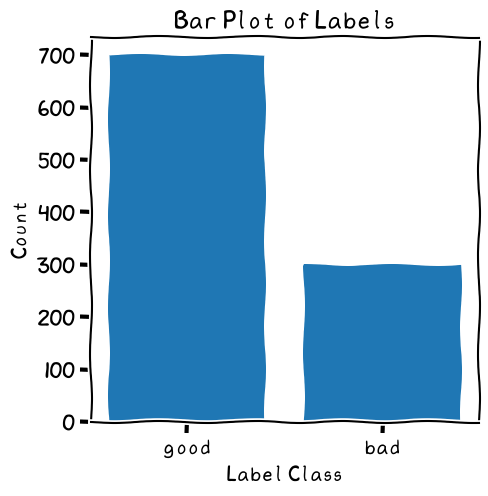

In [12]:
# plot the labels to see whether it is balance or not
label_counts = labels.value_counts()

plt.figure(figsize=(5, 5))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label Class')
plt.ylabel('Count')
plt.title('Bar Plot of Labels')
plt.show()

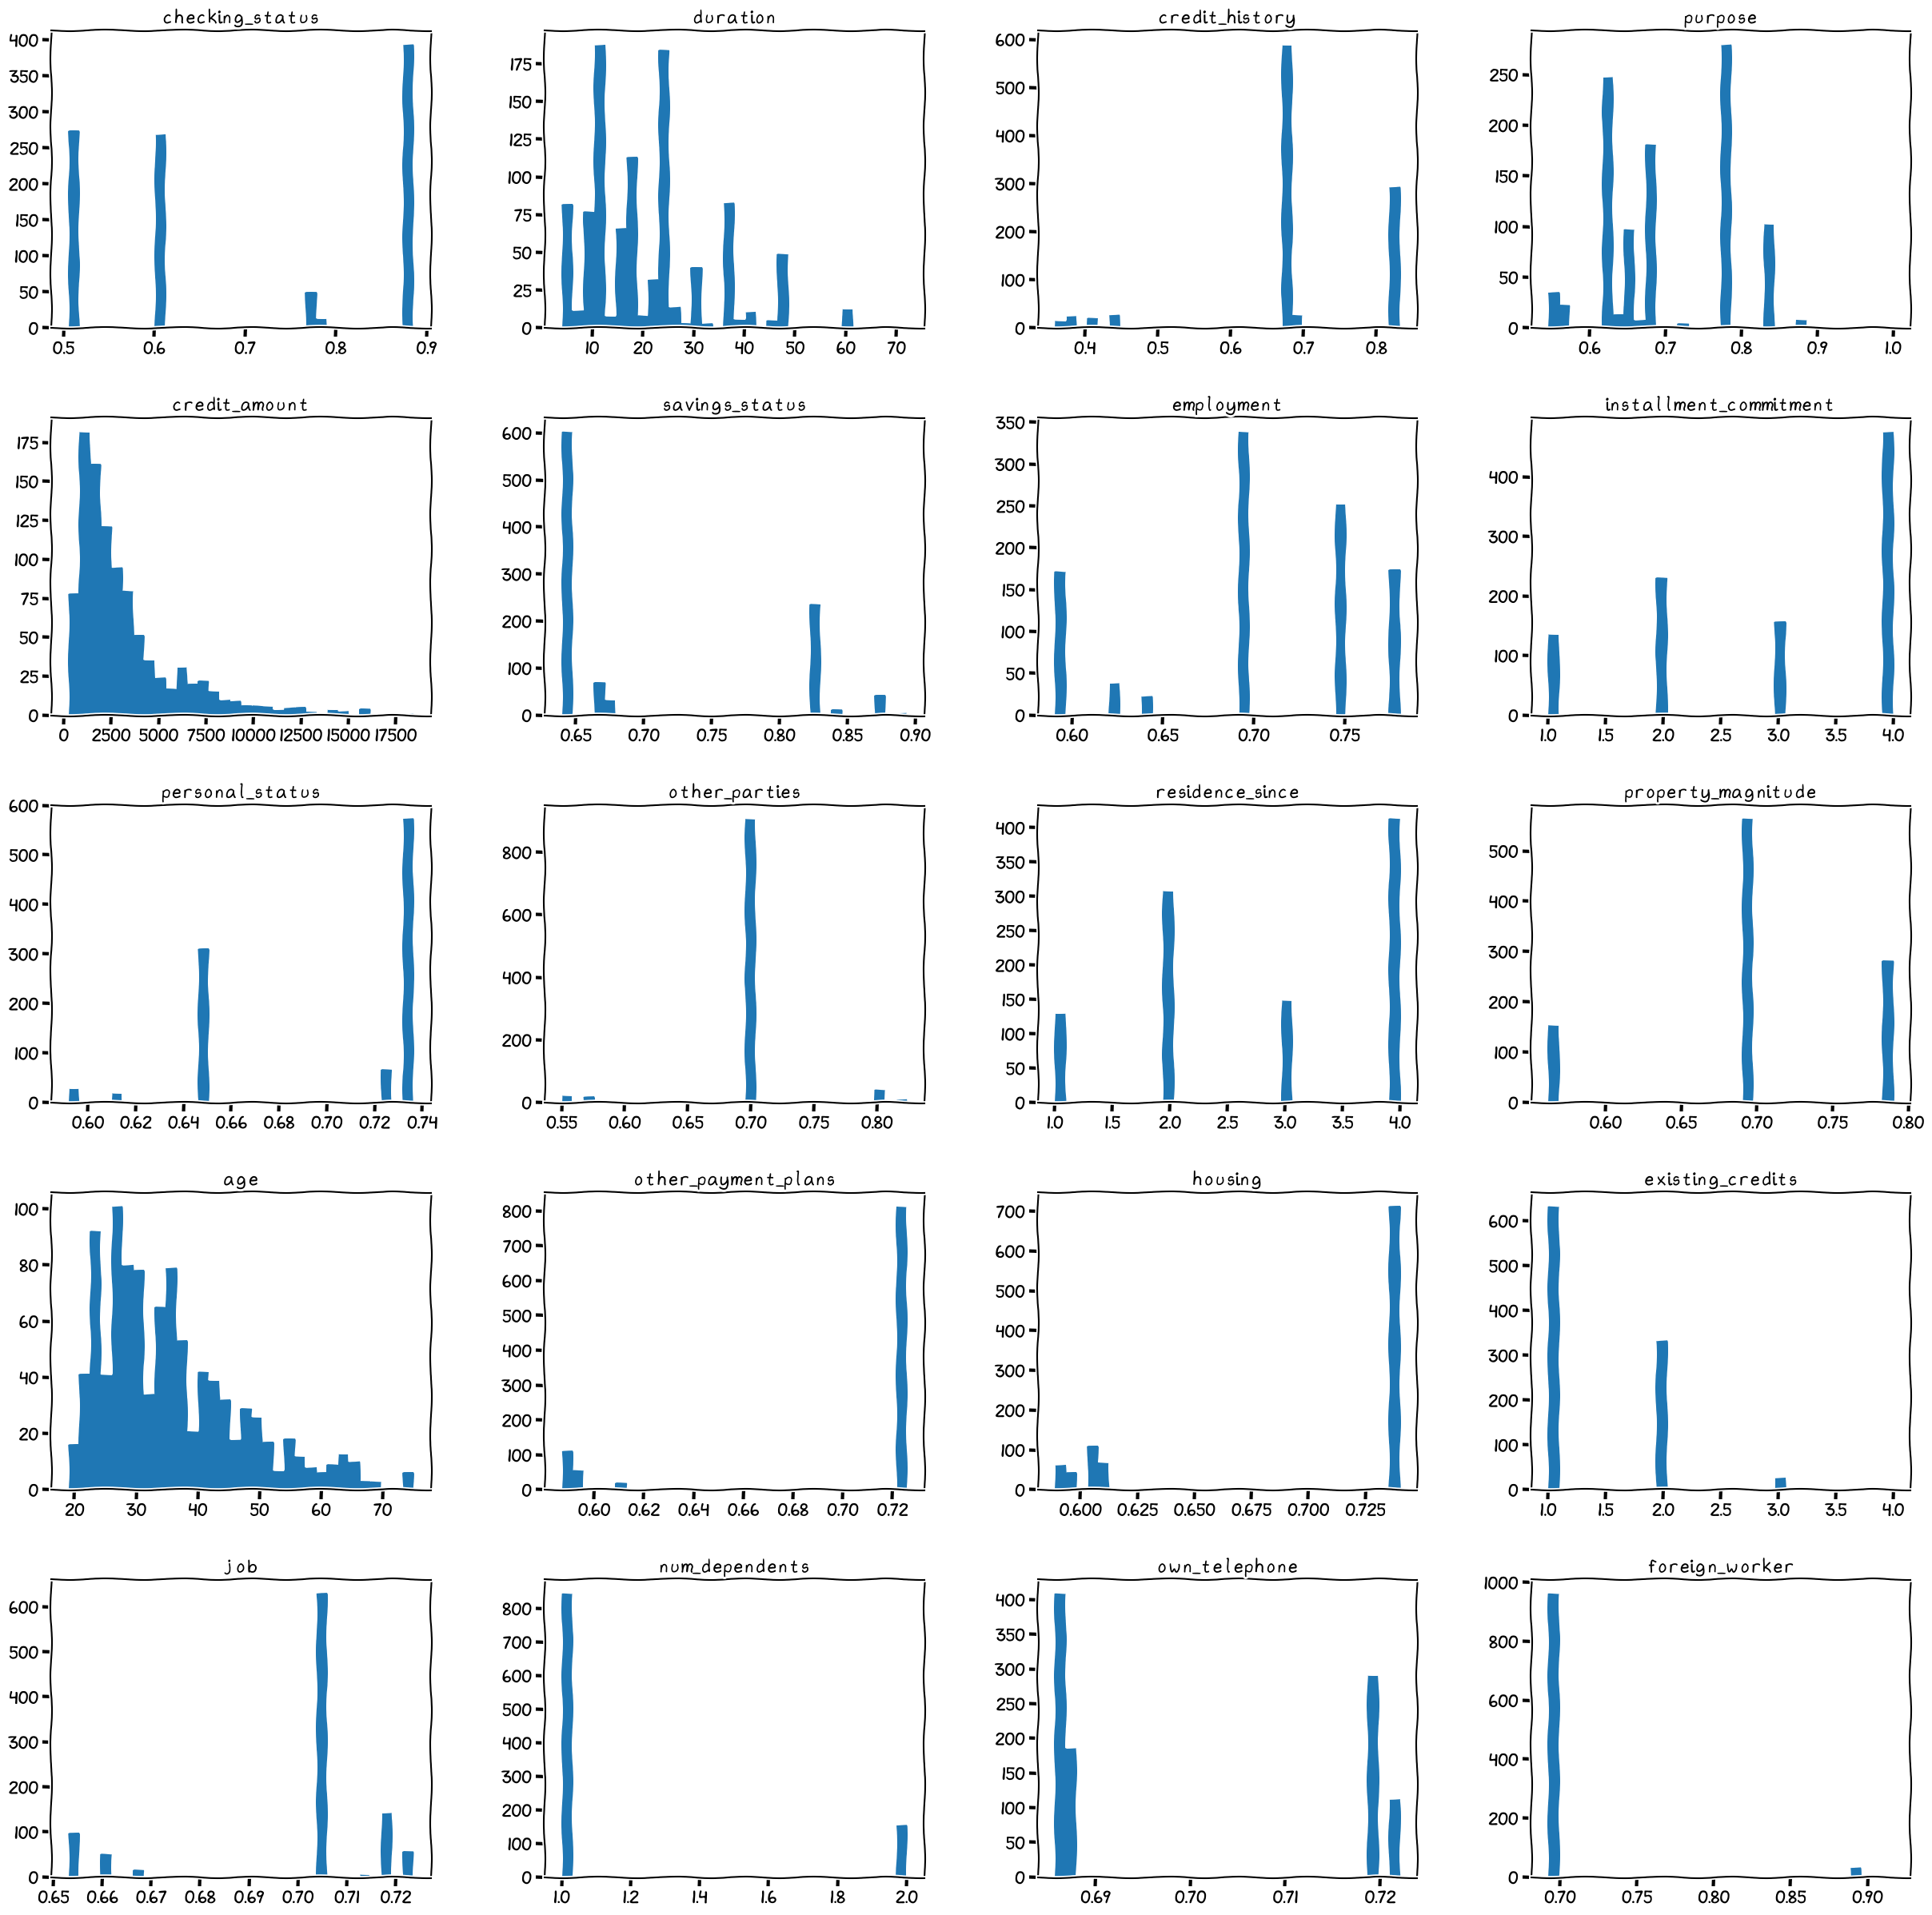

In [26]:
hist = features.hist(figsize=(30, 30), grid=False, bins='sqrt', histtype='stepfilled')

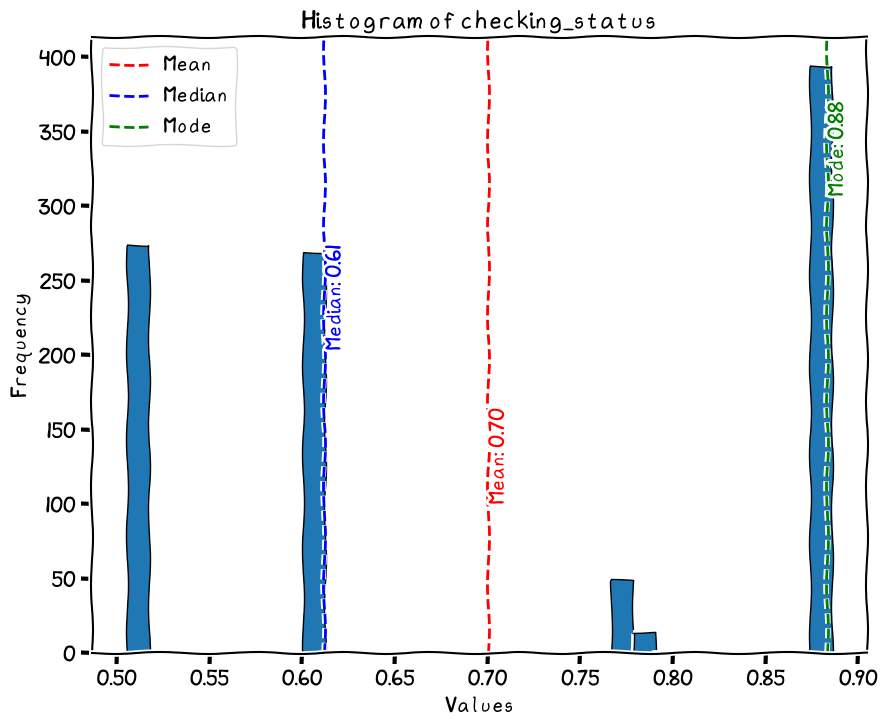

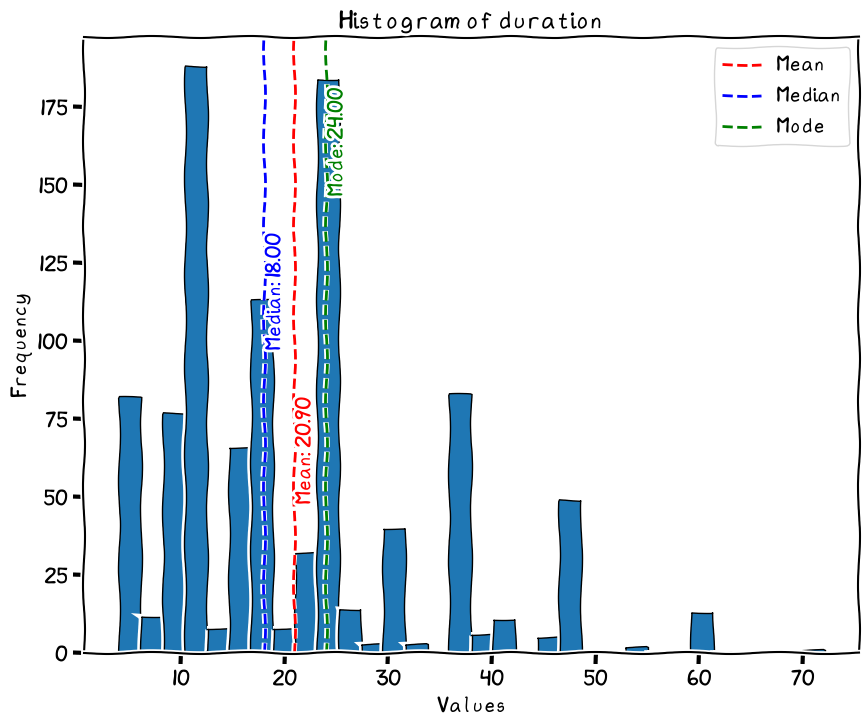

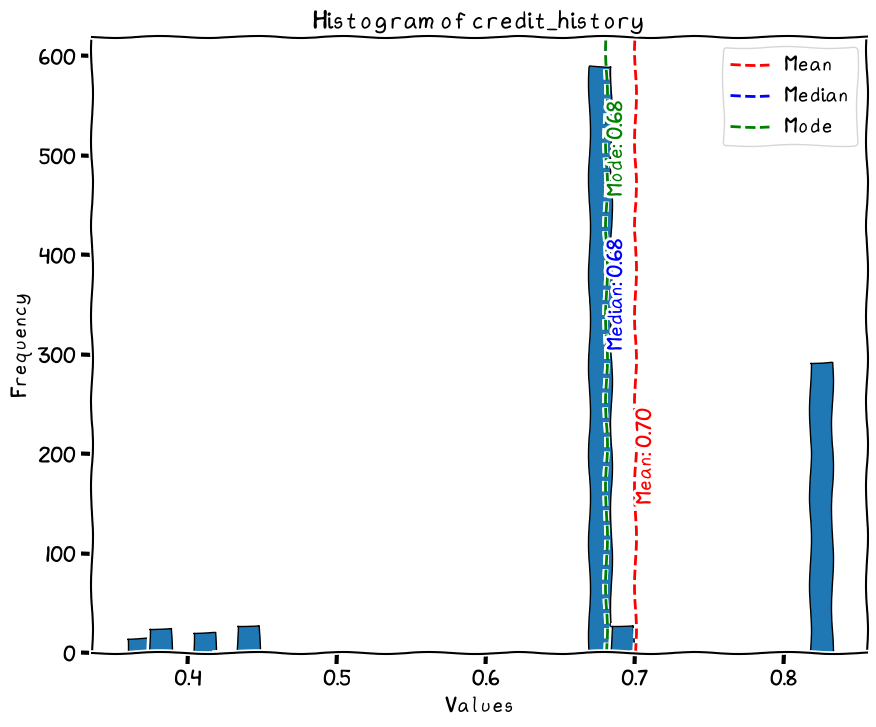

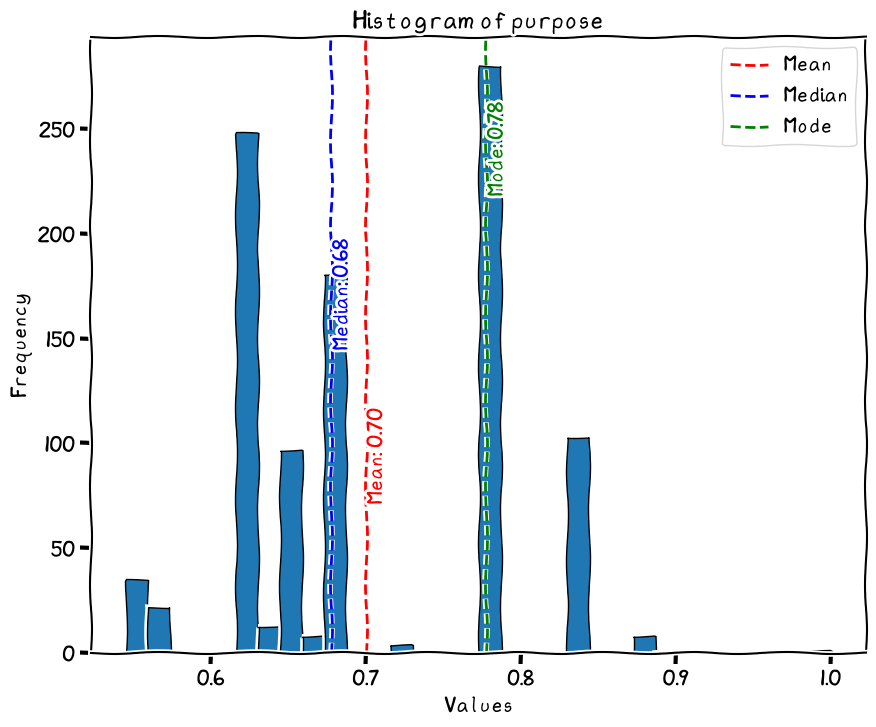

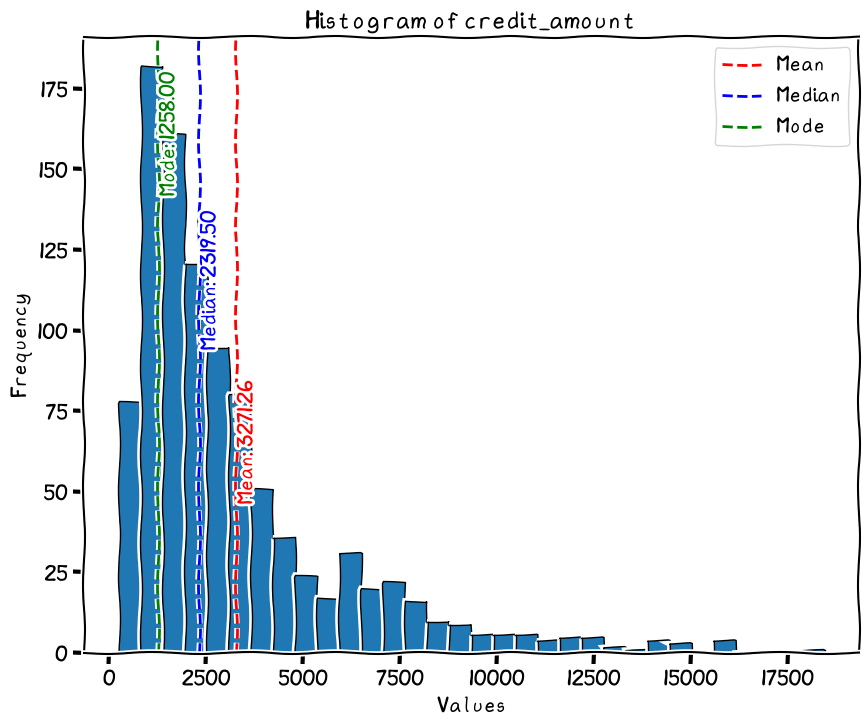

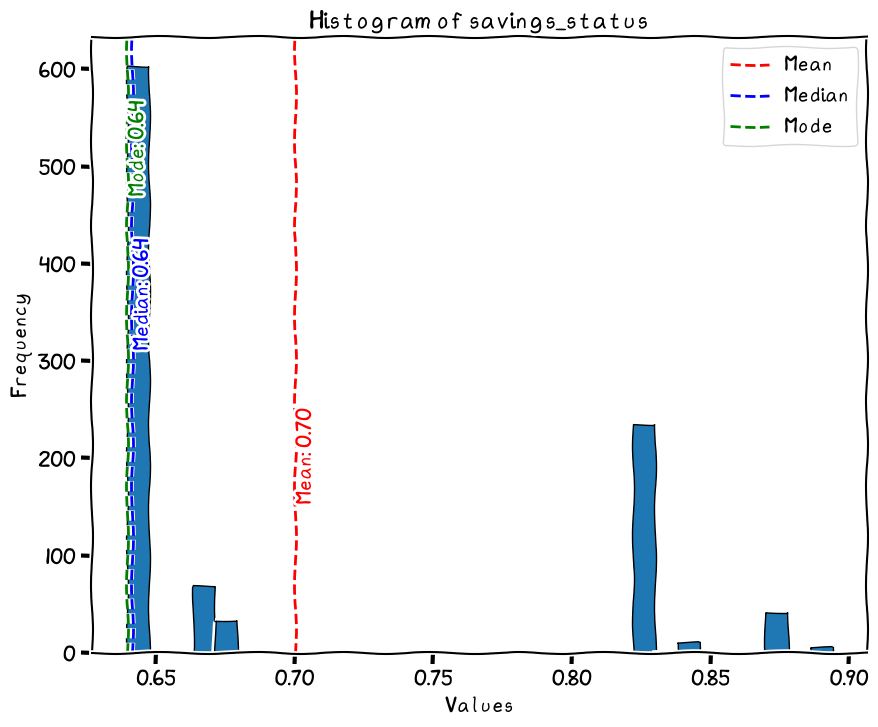

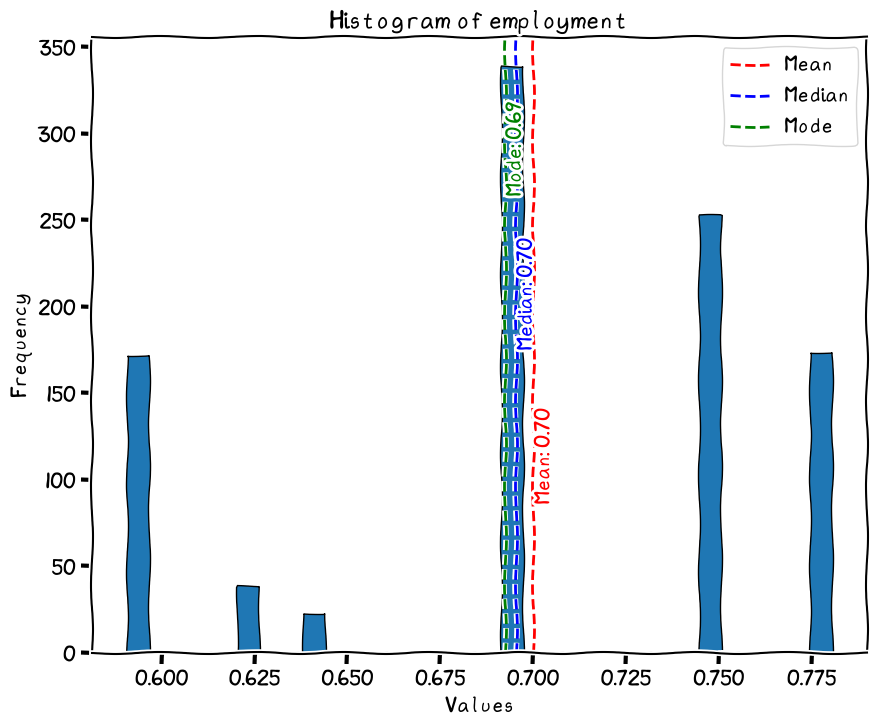

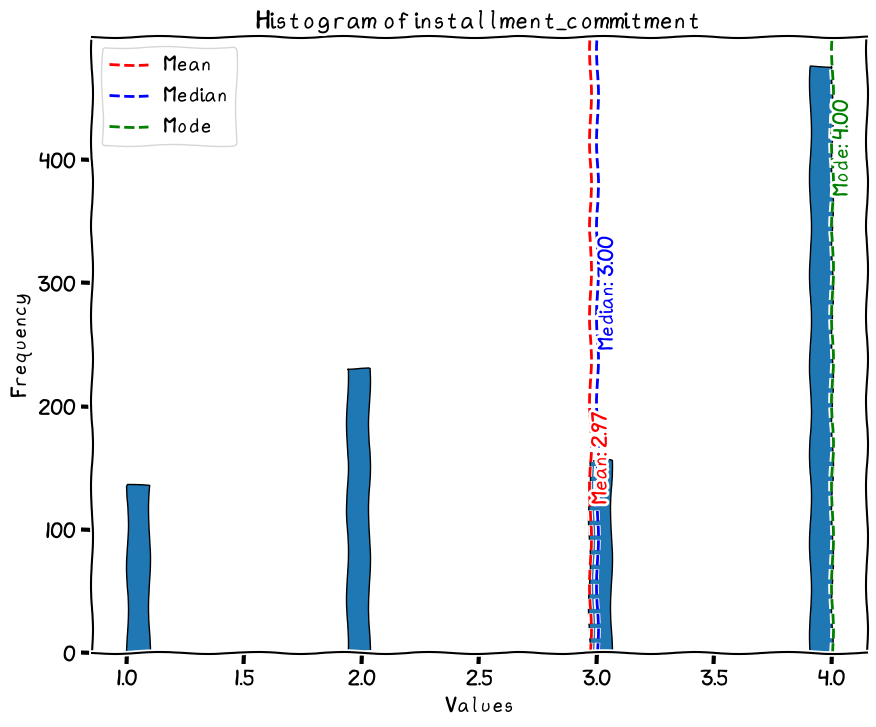

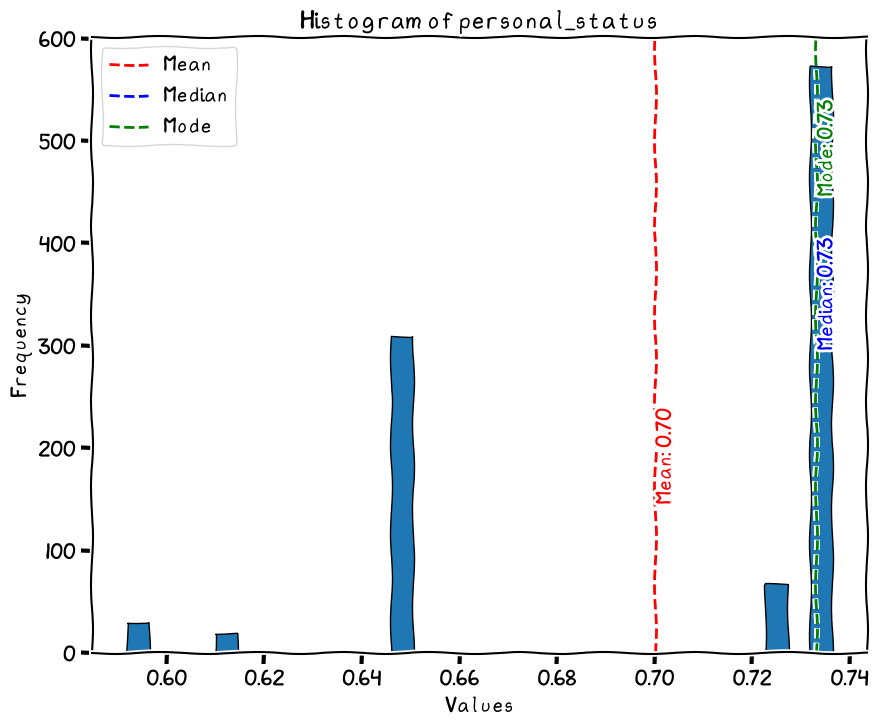

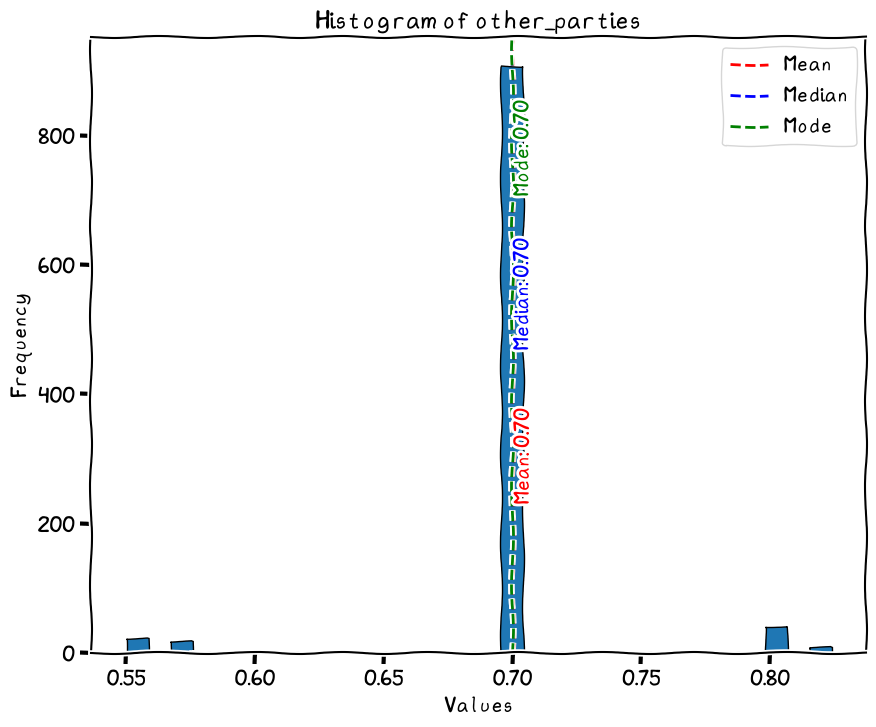

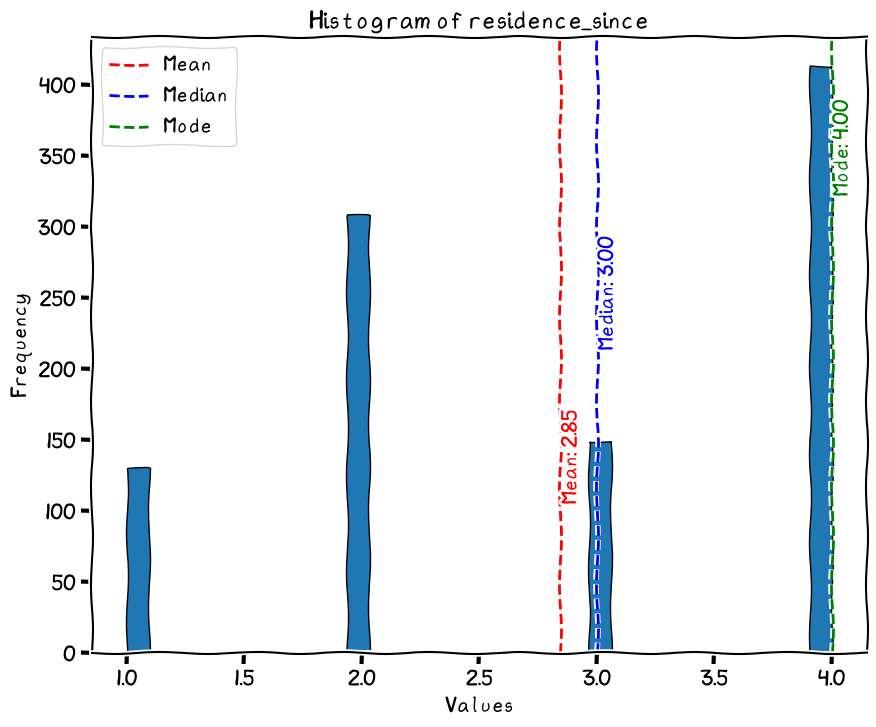

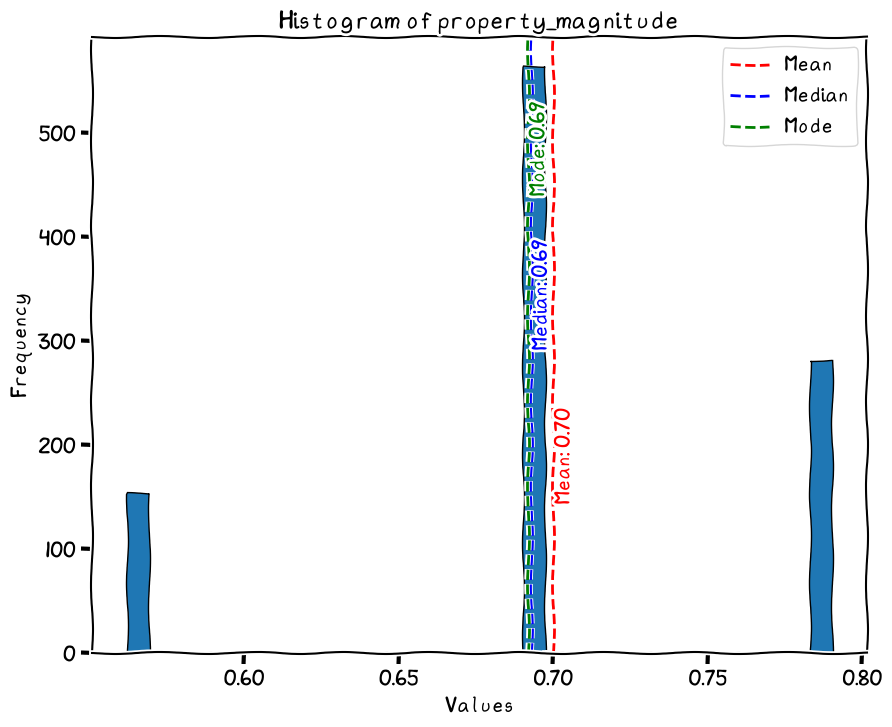

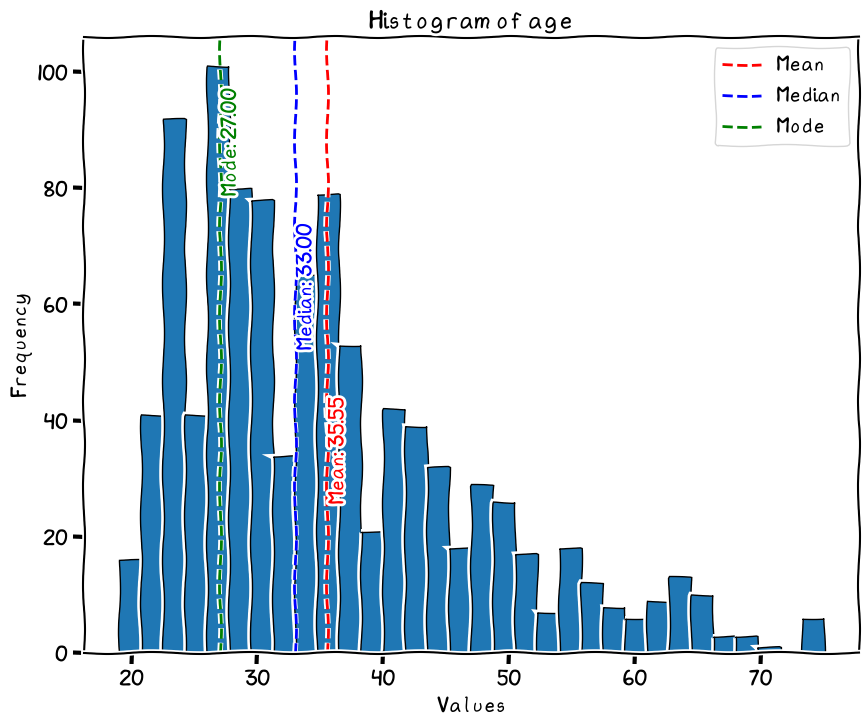

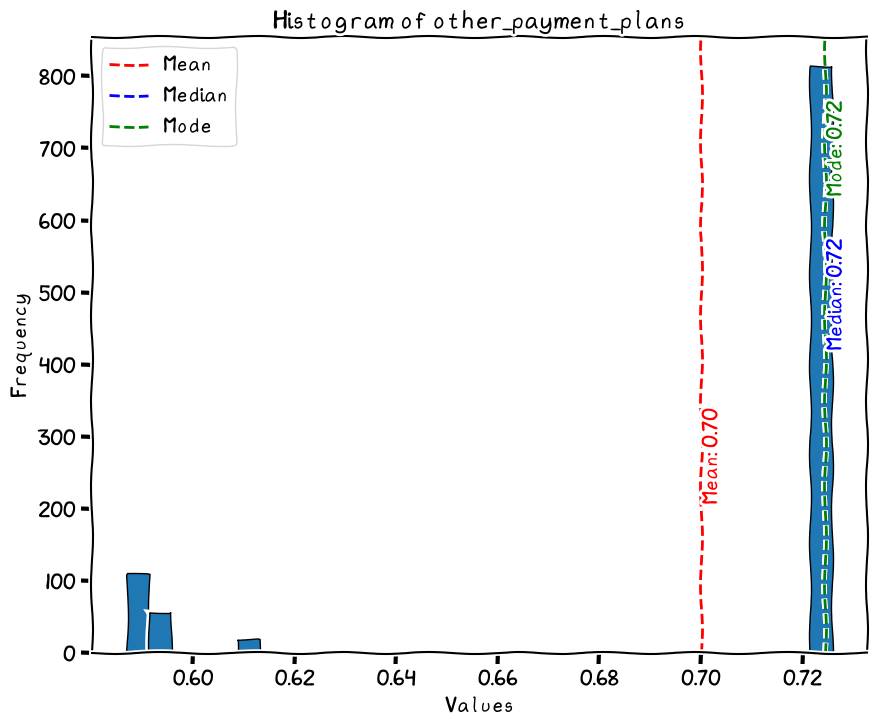

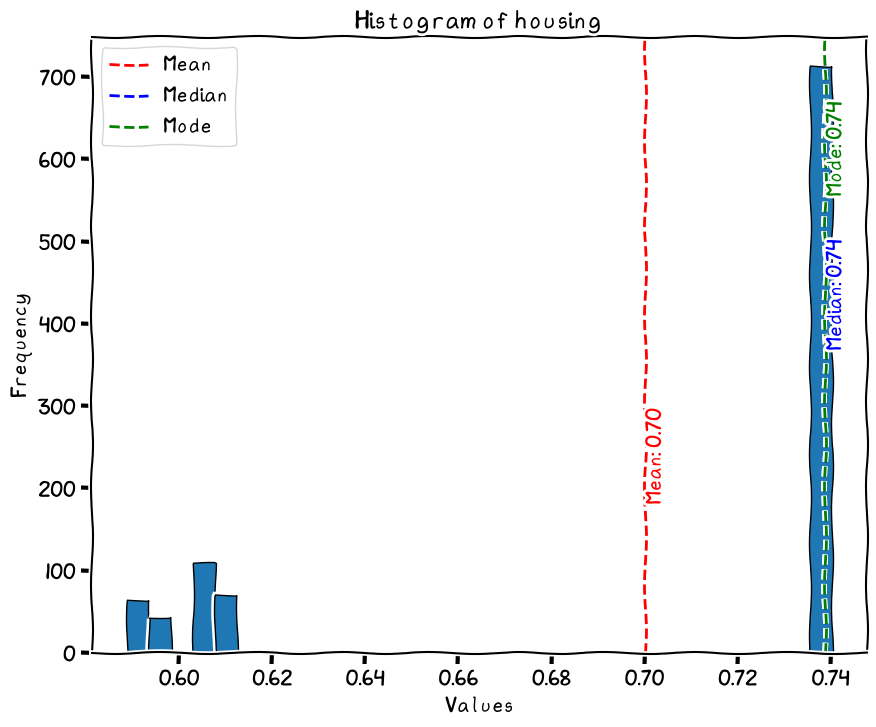

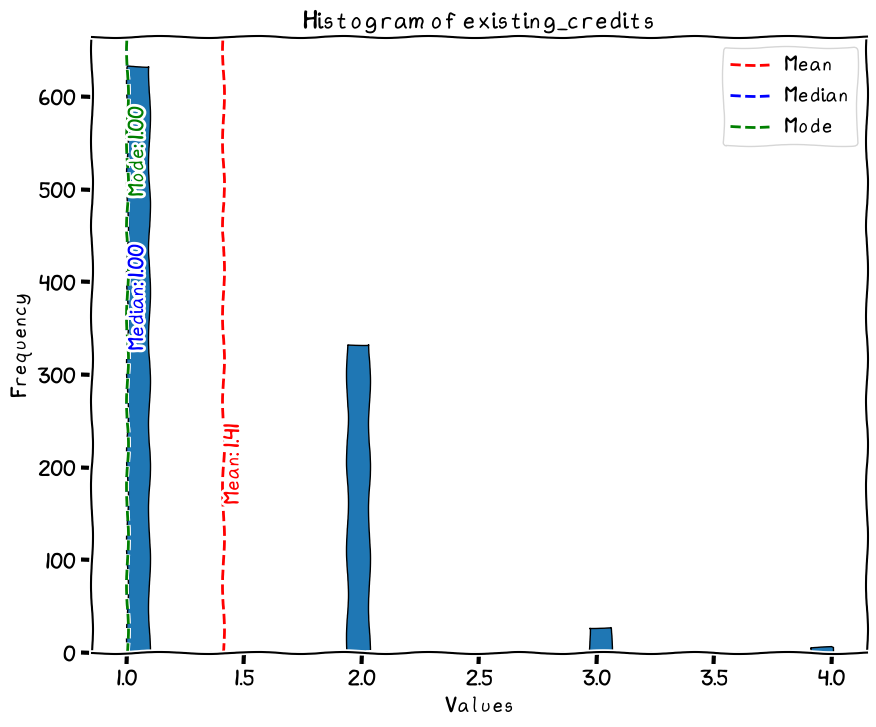

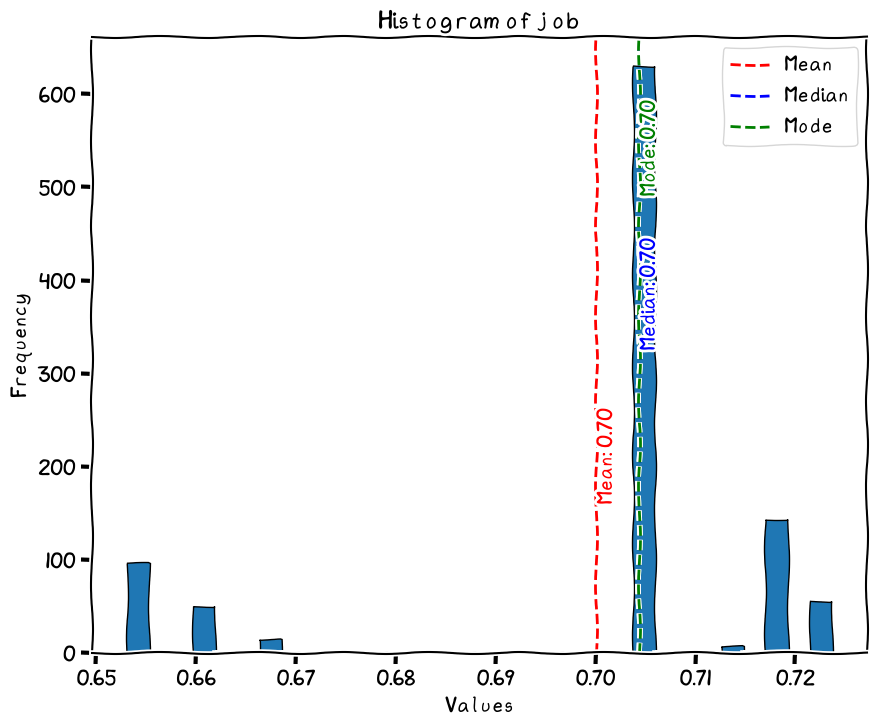

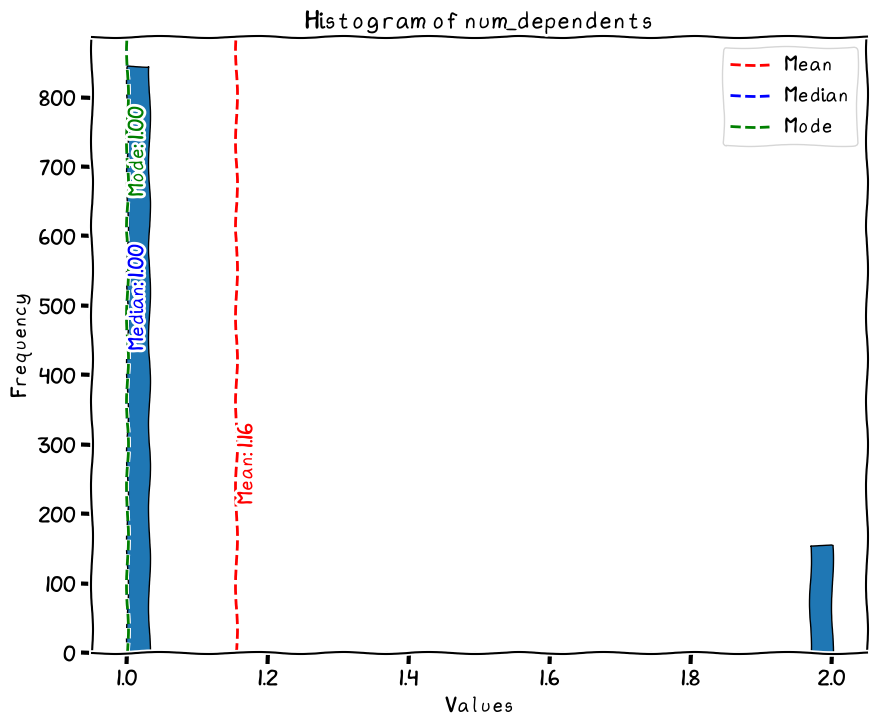

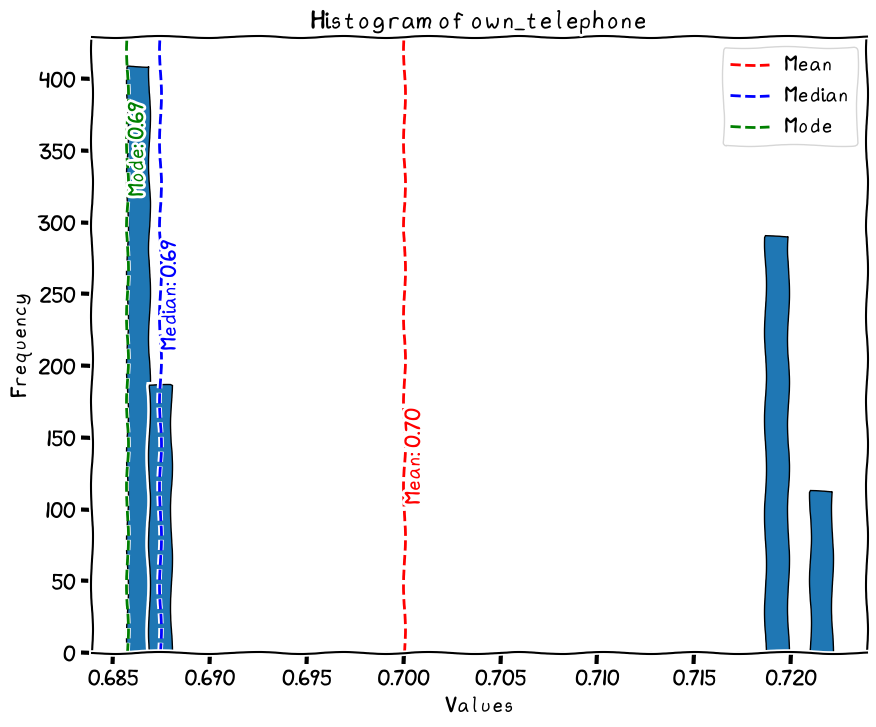

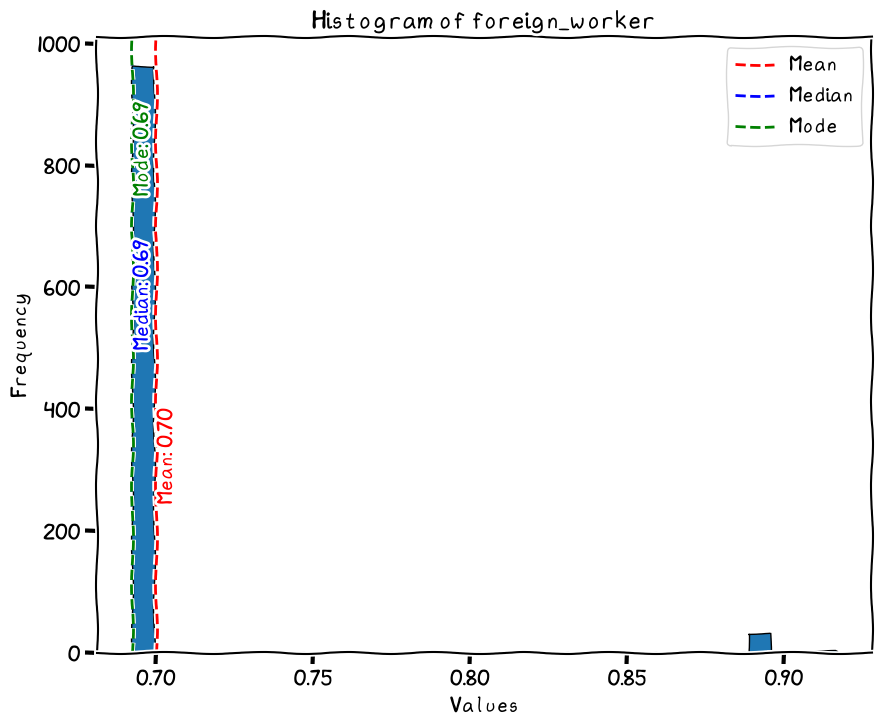

In [49]:
for feat in features.columns:
    plot_histogram(features[feat])

In [54]:
print('skew\t', round(features['checking_status'].skew(), 6))
print('kurt\t', round(features['checking_status'].kurt(), 6))
print(features['checking_status'].describe())

skew	 0.070584
kurt	 -1.754806
count    1000.000000
mean        0.700000
std         0.161283
min         0.505495
25%         0.509158
50%         0.611940
75%         0.882952
max         0.885496
Name: checking_status, dtype: float64


In [55]:
for feat in features.columns:
    print('skew\t', round(features[feat].skew(), 6))
    print('kurt\t', round(features[feat].kurt(), 6))
    print(features[feat].describe(), end='\n\n')

skew	 0.070584
kurt	 -1.754806
count    1000.000000
mean        0.700000
std         0.161283
min         0.505495
25%         0.509158
50%         0.611940
75%         0.882952
max         0.885496
Name: checking_status, dtype: float64

skew	 1.094184
kurt	 0.919781
count       1000.0
mean        20.903
std      12.058814
min            4.0
25%           12.0
50%           18.0
75%           24.0
max           72.0
Name: duration, dtype: Float64

skew	 -1.175146
kurt	 1.774459
count    1000.000000
mean        0.700000
std         0.113943
min         0.358974
25%         0.680529
50%         0.680529
75%         0.828767
max         0.832192
Name: credit_history, dtype: float64

skew	 0.247203
kurt	 -1.094125
count    1000.000000
mean        0.700000
std         0.084233
min         0.545455
25%         0.622318
50%         0.677778
75%         0.777778
max         1.000000
Name: purpose, dtype: float64

skew	 1.949628
kurt	 4.29259
count         1000.0
mean        3271.258
std      2

## Feature Engineering

## Modelling

## Evaluation 

## Future Works

1. Although we utilized the original .arrf dataset which contains both numerical and categorical data for our analysis, we have only explored feature engineering based on this version. In future works, it could be beneficial to compare the results with other versions of the dataset, such as the numerical version.

2. A notable attribute in our dataset is `personal_status`, which is a composite feature that includes both gender and marital status. In our current approach, these features are combined into a single attribute. However, it is possible that separating these features might provide different insights and potentially improve model performance. In future works, we could explore the impact of separating composite features like this into individual attributes.

3. As discussed in the [Attribute Description](#attribute-description), determining the optimal combination of features is crucial. The way we perceive data - whether it's nominal, ordinal, or ratio - can significantly affect the quality of features for model training. Therefore, exploring various feature combinations to improve model performance will be an interesting future direction.

4. Our current work primarily focuses on:
    - **Descriptive Statistics**: We provided summary statistics including means, medians, ranges, and standard deviations, and visualized the data.
    - **Exploratory Data Analysis (EDA)**: We generated and answered our own questions to better understand the dataset.
    - **Predictive Analysis**: We constructed a model to predict future outcomes, in this case, the potential future applicants. 

5. However, there are several important areas we have not yet addressed:
    - **Inferential Statistics**: This involves the use of statistical tests to draw conclusions about a larger population based on a sample. For example, we could use a t-test to see if the means of two groups are significantly different.
    - **Hypothesis Testing**: We haven't tested any assumptions about specific population parameters.
    - **Prescriptive Analysis**: While our predictive analysis focuses on forecasting future outcomes, prescriptive analysis suggests actions that could be taken to benefit from these predictions. This could be a valuable addition to our analysis in the future.

## References

- [Stop One-Hot Encoding Your Categorical Variables](https://medium.com/analytics-vidhya/stop-one-hot-encoding-your-categorical-variables-bbb0fba89809)
- [Don’t use One-Hot Encoding Anymore!!!](https://medium.com/@kaoningyu/dont-use-one-hot-encoding-anymore-25b5882e533f)